In [148]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from pyquery import PyQuery as pq
import requests
import urllib2
from bs4 import BeautifulSoup
import re
%matplotlib inline
import pickle
import collections
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression

In [3]:
artists = pd.read_csv('artists.csv')
# profiles = pd.read_csv('profiles.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
GLOBAL_MEDIAN = 118
VAL_SIZE = 10000

In [8]:
# set up training and validation
train_df = train.head(len(train) - VAL_SIZE)
val_df = train.tail(VAL_SIZE)

### Calculate User Median (done for us)

In [165]:
import numpy as np
import csv

# Predict via the user-specific median.
# If the user has no data, use the global median.

train_file = 'train.csv'
test_file  = 'test.csv'
soln_file  = 'user_median.csv'

# Load the training data.
train_data = {}
with open(train_file, 'r') as train_fh:
    train_csv = csv.reader(train_fh, delimiter=',', quotechar='"')
    next(train_csv, None)
    for row in train_csv:
        user   = row[0]
        artist = row[1]
        plays  = row[2]
    
        if not user in train_data:
            train_data[user] = {}
        
        train_data[user][artist] = int(plays)

# Compute the global median and per-user median.
plays_array  = []
user_medians = {}
for user, user_data in train_data.iteritems():
    user_plays = []
    for artist, plays in user_data.iteritems():
        plays_array.append(plays)
        user_plays.append(plays)

    user_medians[user] = np.median(np.array(user_plays))
global_median = np.median(np.array(plays_array))

# Write out test solutions.
with open(test_file, 'r') as test_fh:
    test_csv = csv.reader(test_fh, delimiter=',', quotechar='"')
    next(test_csv, None)

    with open(soln_file, 'w') as soln_fh:
        soln_csv = csv.writer(soln_fh,
                              delimiter=',',
                              quotechar='"',
                              quoting=csv.QUOTE_MINIMAL)
        soln_csv.writerow(['Id', 'plays'])

        for row in test_csv:
            id     = row[0]
            user   = row[1]
            artist = row[2]

            if user in user_medians:
                soln_csv.writerow([id, user_medians[user]])
            else:
                print "User", id, "not in training data."
                soln_csv.writerow([id, global_median])

In [9]:
train.head(1)

,user,artist,plays
0,eb1c57ddc9e0e2d005169d3a1a96e8dd95e3af03,5a8e07d5-d932-4484-a7f7-e700793a9c94,554


### Calculate Artist Medians * IN RELATION TO USER MEDIAN!!

In [42]:
artist_plays_normalized = collections.defaultdict(list)
artist_plays = collections.defaultdict(list)
for id, row in train_df.iterrows():
    # do I need to normalize this to give everyone the same weight? ie write as a fraction?
    artist = row['artist']
    diff_user_plays_from_user_median = row['plays'] - user_medians[row['user']]
    diff_user_plays_from_user_median_normalized = (row['plays']) / float(user_medians[row['user']])
    artist_plays_normalized[artist].append(diff_user_plays_from_user_median_normalized)
    artist_plays[artist].append(diff_user_plays_from_user_median)

In [21]:
print "user_id: eb1c57ddc9e0e2d005169d3a1a96e8dd95e3af03 artist_id: 5a8e07d5-d932-4484-a7f7-e700793a9c94 554"
print "plays: 554 user_median: 502.0"
artist_plays["5a8e07d5-d932-4484-a7f7-e700793a9c94"], artist_plays_normalized["5a8e07d5-d932-4484-a7f7-e700793a9c94"]

user_id: eb1c57ddc9e0e2d005169d3a1a96e8dd95e3af03 artist_id: 5a8e07d5-d932-4484-a7f7-e700793a9c94 554
plays: 554 user_median: 502.0


(defaultdict(list, {'artist': [52.0]}),
 defaultdict(list, {'artist': [1.1035856573705178]}))

In [50]:
artists.head(5)

,artist,name
0,03098741-08b3-4dd7-b3f6-1b0bfa2c879c,Liars
1,69c4cc43-8163-41c5-ac81-30946d27bb69,CunninLynguists
2,7a2e6b55-f149-4e74-be6a-30a1b1a387bb,The Desert Sessions
3,7002bf88-1269-4965-a772-4ba1e7a91eaa,Glenn Gould
4,dbf7c761-e332-467b-b4d9-aafe06bbcf8f,G. Love & Special Sauce


#### What do these distributions look like? Is this reasonable?

(array([  1.29600000e+03,   1.60000000e+02,   2.10000000e+01,
          9.00000000e+00,   5.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  0.04615385,   1.76366236,   3.48117086,   5.19867937,
          6.91618788,   8.63369639,  10.3512049 ,  12.06871341,
         13.78622192,  15.50373043,  17.22123894]),
 <a list of 10 Patch objects>)

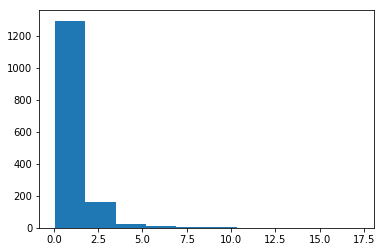

In [123]:
plt.hist(artist_plays_normalized["5a8e07d5-d932-4484-a7f7-e700793a9c94"])

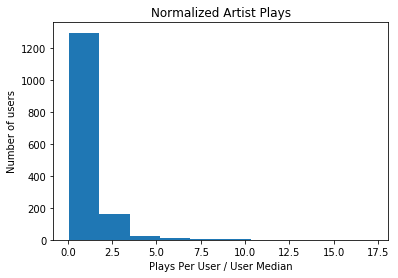

In [241]:
plt.hist(artist_plays_normalized["5a8e07d5-d932-4484-a7f7-e700793a9c94"])
plt.title("Normalized Artist Plays")
plt.ylabel("Number of users")
plt.xlabel("Plays Per User / User Median")

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   4.50000000e+01,
          1.40200000e+03,   3.60000000e+01,   9.00000000e+00,
          1.00000000e+00]),
 array([-2712.  , -2286.55, -1861.1 , -1435.65, -1010.2 ,  -584.75,
         -159.3 ,   266.15,   691.6 ,  1117.05,  1542.5 ]),
 <a list of 10 Patch objects>)

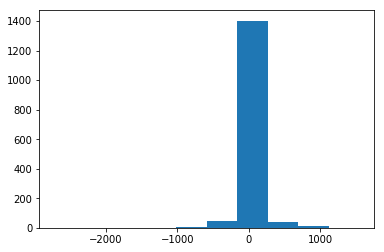

In [56]:
plt.hist(artist_plays["5a8e07d5-d932-4484-a7f7-e700793a9c94"])

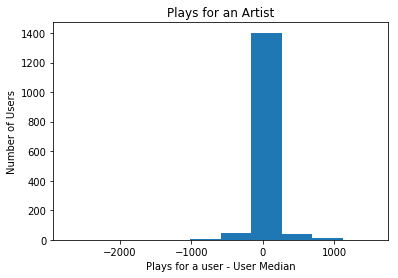

In [242]:
plt.hist(artist_plays["5a8e07d5-d932-4484-a7f7-e700793a9c94"])
plt.title("Plays for an Artist")
plt.xlabel("Plays for a user - User Median")
plt.ylabel("Number of Users")

In [47]:
np.mean(artist_plays_normalized["5a8e07d5-d932-4484-a7f7-e700793a9c94"]), np.median(artist_plays_normalized["5a8e07d5-d932-4484-a7f7-e700793a9c94"])

(1.1887402342016555, 0.91073738680465721)

#### What does the mean/medians for artists look like? Is this reasonable? (when count differences are not normalized)

In [75]:
artist_means = collections.defaultdict(int)
for artist in artist_plays.keys():
    # create a dictionary of all the artist means (can choose median as well)
    artist_means[artist] = np.mean(artist_plays[artist])

In [83]:
artist_medians = collections.defaultdict(int)
for artist in artist_plays.keys():
    # create a dictionary of all the artist means (can choose median as well)
    artist_medians[artist] = np.median(artist_plays[artist])

(array([ 662.,  863.,  329.,   99.,   28.,   10.,    6.,    1.,    1.,    1.]),
 array([ -28.00306373,   31.30804265,   90.61914902,  149.93025539,
         209.24136176,  268.55246814,  327.86357451,  387.17468088,
         446.48578725,  505.79689363,  565.108     ]),
 <a list of 10 Patch objects>)

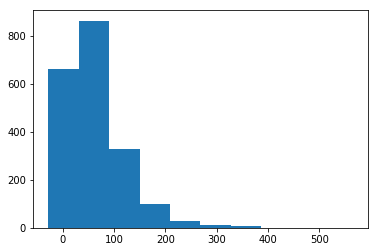

In [77]:
plt.hist(list(artist_means.values()))

nan


(array([  6.40000000e+01,   1.45600000e+03,   3.47000000e+02,
          7.60000000e+01,   3.10000000e+01,   1.10000000e+01,
          8.00000000e+00,   4.00000000e+00,   3.00000000e+00,
          1.00000000e+00]),
 array([-15.  ,  -7.15,   0.7 ,   8.55,  16.4 ,  24.25,  32.1 ,  39.95,
         47.8 ,  55.65,  63.5 ]),
 <a list of 10 Patch objects>)

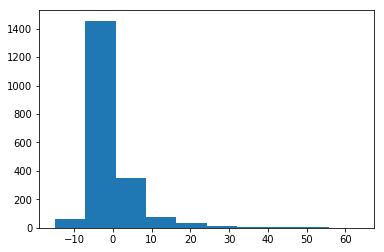

In [114]:
values = []
for value in list(artist_median.values()):
    if np.isnan(value):
        print value
        continue
    values.append(value)
plt.hist(values)

In [115]:
artist_means = collections.defaultdict(int)
for artist in artist_plays_normalized.keys():
    # create a dictionary of all the artist means (can choose median as well)
    artist_means[artist] = np.mean(artist_plays_normalized[artist])

nan


(array([ 803.,  903.,  216.,   51.,   19.,    4.,    1.,    0.,    2.,    1.]),
 array([ 0.87194938,  1.3344976 ,  1.79704582,  2.25959405,  2.72214227,
         3.18469049,  3.64723871,  4.10978693,  4.57233515,  5.03488338,
         5.4974316 ]),
 <a list of 10 Patch objects>)

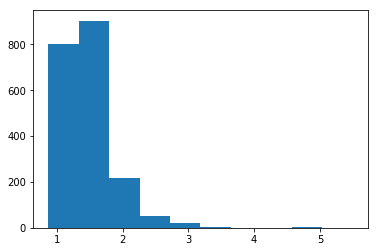

In [117]:
values = []
for value in list(artist_means.values()):
    if np.isnan(value):
        print value
        continue
    values.append(value)
plt.hist(values)

nan


(array([  23.,  256.,  700.,  820.,  121.,   49.,   14.,   10.,    4.,    3.]),
 array([ 0.73879599,  0.82203792,  0.90527985,  0.98852178,  1.07176372,
         1.15500565,  1.23824758,  1.32148952,  1.40473145,  1.48797338,
         1.57121531]),
 <a list of 10 Patch objects>)

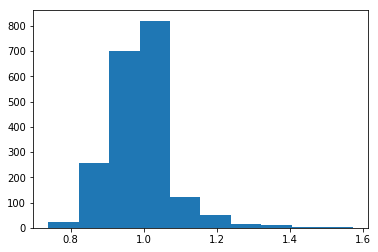

In [167]:
artist_medians = collections.defaultdict(int)
for artist in artist_plays_normalized.keys():
    # create a dictionary of all the artist means (can choose median as well)
    artist_medians[artist] = np.median(artist_plays_normalized[artist])
values = []
for value in list(artist_medians.values()):
    if np.isnan(value):
        print value
        continue
    values.append(value)

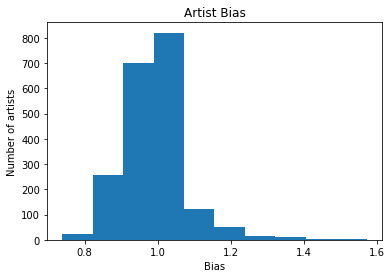

In [240]:
plt.hist(values)
plt.title("Artist Bias")
plt.ylabel("Number of artists")
plt.xlabel("Bias")

### Artist Medians Normalized

In [127]:
artist_medians_pair = []
user_medians_pair = []
for _, row in train.iterrows():
    artist = row['artist']
    user = row['user']
    artist_medians_pair.append(artist_medians[artist])
    user_medians_pair.append(user_medians[user])

In [126]:
artist_medians_pair, user_medians_pair

([0.91073738680465721], [502.0])

In [136]:
# update overall train
train['artist_median'] = artist_medians_pair
train['user_median'] = user_medians_pair
# recreate training and validation
val_df = train.tail(VAL_SIZE)
train_df = train.head(len(train) - VAL_SIZE)
# create the matrices we need
X_train = np.matrix(train_df[['user_median', 'artist_median']])
Y_train = train_df['plays']
X_val = np.matrix(val_df[['user_median', 'artist_median']])
Y_val = val_df['plays']

In [137]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((4144804, 2), (4144804,), (10000, 2), (10000,))

### Train models for X

#### Random Forest

In [138]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train.ravel())
rf_preds = rf.predict(X_val)

In [143]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_val, rf_preds)

158.39721986759628

In [144]:
baseline_preds = []
for _, row in val_df.iterrows():
    pred = user_medians[row['user']]
    baseline_preds.append(pred)

In [145]:
mean_absolute_error(Y_val, baseline_preds)

122.5065

#### Linear Regression

In [146]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr_preds = lr.predict(X_val)

/Users/belinda/.virtualenvs/cs181/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [147]:
mean_absolute_error(Y_val, lr_preds)

147.29833694449849

In [151]:
br = BayesianRidge(compute_score=True)
br.fit(X_train, Y_train)
br_preds = br.predict(X_val)

In [152]:
mean_absolute_error(Y_val, br_preds)

147.29760369097929

In [159]:
lr.coef_

array([   1.37805321,  514.13943376])

In [160]:
br.coef_

array([   1.378054  ,  514.09380036])

In [161]:
val_df.head(5)

,user,artist,plays,artist_median,user_median
4144804,13bb116eb0f017573577a6f20d1caf9f1fb65129,c71abd83-9d66-4c7b-9f0d-c9c36e85a955,142,0.884848,212.0
4144805,601a9fa3d29e1cf0cf7cfbceba49ebaae6f5d53b,ea5883b7-68ce-48b3-b115-61746ea53b8c,19,1.000000,23.0
4144806,7940a5467ff020970dbb9a132c0338fd7f75bb75,7570a0dd-5a67-401b-b19a-261eee01a284,60,1.061047,69.5
4144807,223e788779ad60eba76da997bf393f23244b240c,00eeed6b-5897-4359-8347-b8cd28375331,96,1.000000,88.0
4144808,5f4ed2614b40fbec9739492ebdf6ffedf795d2a2,e631bb92-3e2b-43e3-a2cb-b605e2fb53bd,418,1.000000,811.0


#### Product

In [162]:
val_preds = []
for _, row in val_df.iterrows():
    pred = row['user_median']*row['artist_median']
    val_preds.append(pred)

In [163]:
mean_absolute_error(Y_val, val_preds)

121.562295847733

### X_test

In [181]:
test_preds = []
user_medians_test = []
artist_medians_test = []
for _, row in test.iterrows():
    user_medians_test.append(user_medians[row['user']])
    artist_medians_test.append(artist_medians[row['artist']])
    pred = user_medians[row['user']]*artist_medians[row['artist']]
    test_preds.append(pred)

In [ ]:
test['user_median'] = user_medians_test
test['artist_median'] = artist_medians_test
test['artist_times_user'] = test_preds
test.to_csv('test-user-artist-medians.csv')

In [183]:
def write_predictions(filename, test, preds):
    soln_file = filename
    # Write out test solutions.
    with open(soln_file, 'w') as soln_fh:
        soln_csv = csv.writer(soln_fh,
                              delimiter=',',
                              quotechar='"',
                              quoting=csv.QUOTE_MINIMAL)
        soln_csv.writerow(['Id', 'plays'])

        for i in xrange(0, len(test['user'])):
            id = test['Id'][i]
            predictions = preds[i]
            
            soln_csv.writerow([id, predictions])

In [184]:
write_predictions('user-med-artist-multiply.csv', test, test_preds)

In [ ]:
test.to_csv('test-user-artist-medians.csv')

### Now let's try a more sophisticated weighting...

In [186]:
train.head(5)

,user,artist,plays,artist_median,user_median
0,eb1c57ddc9e0e2d005169d3a1a96e8dd95e3af03,5a8e07d5-d932-4484-a7f7-e700793a9c94,554,0.910737,502.0
1,44ce793a6cd9d20f13f4a576a818ef983314bb5d,a3a92047-be1c-4f3e-8960-c4f8570984df,81,1.000000,25.0
2,da9cf3f557161d54b76f24db64be9cc76db008e3,eeb1195b-f213-4ce1-b28c-8565211f8e43,708,0.984962,105.5
3,8fa49ab25d425edcf05d44bfc1d5aea895287d81,a1419808-65d3-4d40-998c-1a0bac65eabc,265,0.977578,311.0
4,b85fcaef67d2669cd99b334b5e8c8705263db2cf,a3cb23fc-acd3-4ce0-8f36-1e5aa6a18432,220,1.023973,125.0


In [187]:
preds = []
for _, row in train.iterrows():
    pred = row['artist_median']*row['user_median']
    preds.append(pred)

In [188]:
train['true_artist'] = preds

#### Creating X and training models

In [198]:
from sklearn.linear_model import Ridge

In [189]:
# recreate training and validation
val_df = train.tail(VAL_SIZE)
train_df = train.head(len(train) - VAL_SIZE)
# create the matrices we need
X_train = np.matrix(train_df[['user_median', 'true_artist']])
Y_train = train_df['plays']
X_val = np.matrix(val_df[['user_median', 'true_artist']])
Y_val = val_df['plays']

In [232]:
br = Ridge(alpha=1000.0)
br.fit(X_train, Y_train)
br_preds = br.predict(X_val)

In [234]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train.ravel())
rf_preds = rf.predict(X_val)

In [ ]:
mean_absolute_error(Y_val, rf_preds)

In [238]:
len(list(set(train['user'])))

233286

In [ ]:
train.groupby(['user'])

### Brian's Code

In [ ]:
user_artist_pairs = {user : 
                     [1 if ((train['user'] == user) & (train['artist'] == artist)).any() else 0 for artist in artists['artist']] for user in profiles['user']}